In [1]:
import math
import matplotlib.pyplot as plt
import pandas
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

In [2]:
def shift_and_scale(series, scaleFactor=1000):
    return (series-min(series))*scaleFactor

In [3]:
def read_and_clean_data(number_of_subjects = 5):
    cgm_all_subjects = []
    dtm_all_subjects = []
    for i in range(1,number_of_subjects + 1):
        cgm_temp_subj = pandas.read_csv("DataFolder\CGMSeriesLunchPat"+str(i)+".csv")
        dtm_temp_subj = pandas.read_csv("DataFolder\CGMDatenumLunchPat"+str(i)+".csv")
        if(cgm_temp_subj.shape[1]>=30 and dtm_temp_subj.shape[1]>=30):
            cgm_temp_subj_30 = cgm_temp_subj.iloc[:, 0:30].values
            dtm_temp_subj_30 = dtm_temp_subj.iloc[:,0:30].values
            cgm_clean_30 = []
            dtm_clean_30 = []
            cleaned = False
            for row_index in range(len(cgm_temp_subj_30)):
                isValid = True
                if len(cgm_temp_subj_30[row_index])==30:
                    for column_index in range(len(cgm_temp_subj_30[row_index])):
                        if np.isnan(cgm_temp_subj_30[row_index][column_index]) or np.isnan(dtm_temp_subj_30[row_index][column_index]):
                            isValid = False
                            #print("invalid row")
                            break
                    if isValid:
                        cgm_clean_30.append(cgm_temp_subj_30[row_index][::-1])
                        dtm_clean_30.append(dtm_temp_subj_30[row_index][::-1])
                        cleaned = True
            if cleaned:
                cgm_all_subjects.append(np.array(cgm_clean_30))
                dtm_all_subjects.append(np.array(dtm_clean_30))
    return (np.asarray(dtm_all_subjects), np.asarray(cgm_all_subjects))

## Main Init

In [4]:
#Main init. 
#Pass number of subjects as argument in case of more subjects.
data = read_and_clean_data(5)
dtm_x_all_subjects = data[0]
cgm_y_all_subjects = data[1]

In [5]:
def get_fig_and_axes(subject_id = 1):
    subject_id -= 1
    rows = (len(cgm_y_all_subjects[subject_id])+1)//2
    fig, ax = plt.subplots(nrows = rows, ncols = 2, figsize = (16,rows*6))
    return fig, ax

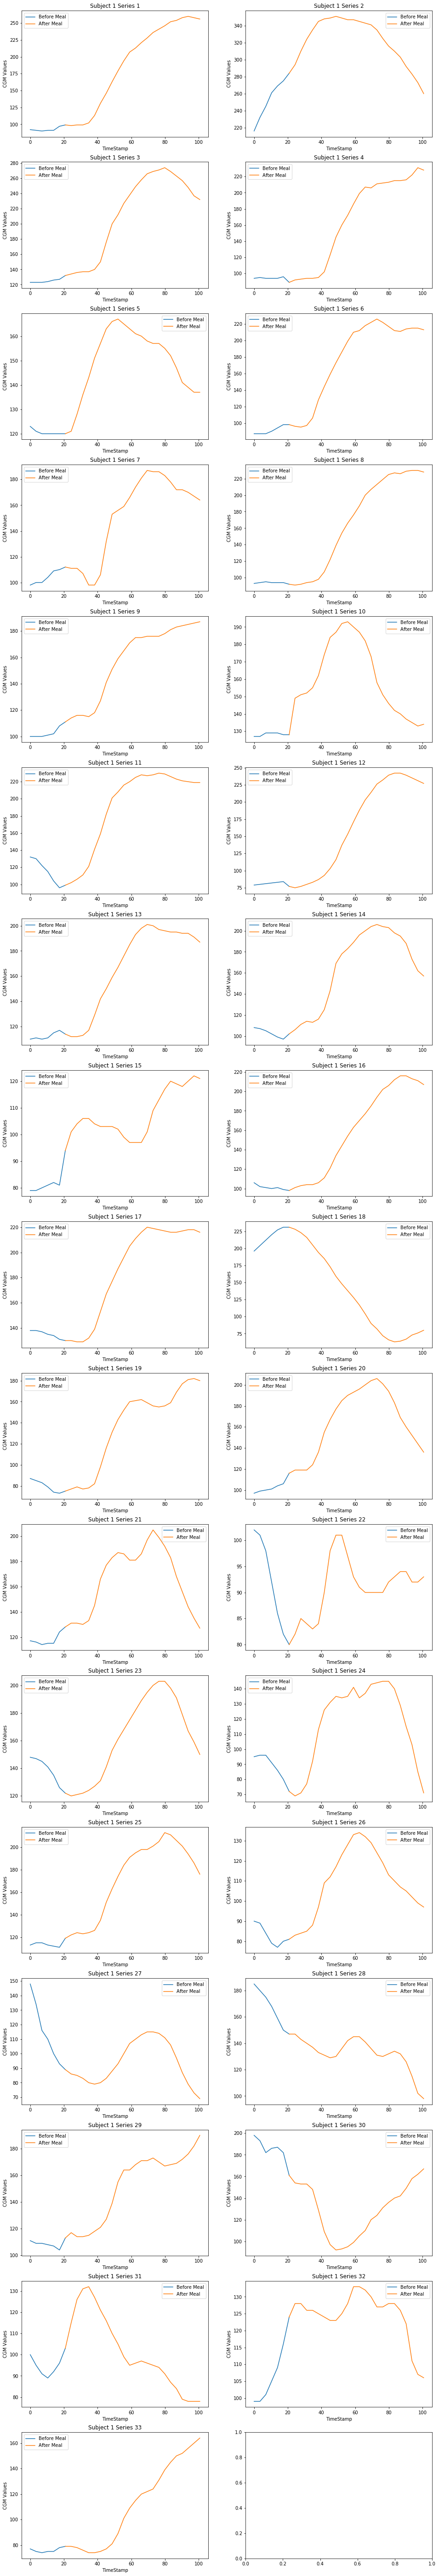

In [6]:
#plot all series of subject

def plot_series_subject(subject_id = 1):
    fig, ax = get_fig_and_axes(subject_id)
    subject_id -= 1
    for i in range(0,len(cgm_y_all_subjects[subject_id]),2):
        minutes = shift_and_scale(dtm_x_all_subjects[subject_id][i])
        ax[i//2][0].plot(minutes[0:7], cgm_y_all_subjects[subject_id][i][0:7], label="Before Meal")
        ax[i//2][0].plot(minutes[6:], cgm_y_all_subjects[subject_id][i][6:], label = "After Meal")
        ax[i//2][0].set_title("Subject "+ str(subject_id+1)+" Series " +str(i+1))
        ax[i//2][0].set_xlabel("TimeStamp")
        ax[i//2][0].set_ylabel("CGM Values")
        ax[i//2][0].legend()
        if i+1<len(cgm_y_all_subjects[subject_id]):
            minutes = shift_and_scale(dtm_x_all_subjects[subject_id][i+1])
            ax[i//2][1].plot(minutes[0:7], cgm_y_all_subjects[subject_id][i+1][0:7], label="Before Meal")
            ax[i//2][1].plot(minutes[6:], cgm_y_all_subjects[subject_id][i+1][6:], label="After Meal")
            ax[i//2][1].set_title("Subject "+str(subject_id+1)+" Series " + str(i+2))
            ax[i//2][1].set_xlabel("TimeStamp")
            ax[i//2][1].set_ylabel("CGM Values")
            ax[i//2][1].legend()

plot_series_subject(1)

## Top 8 DFT

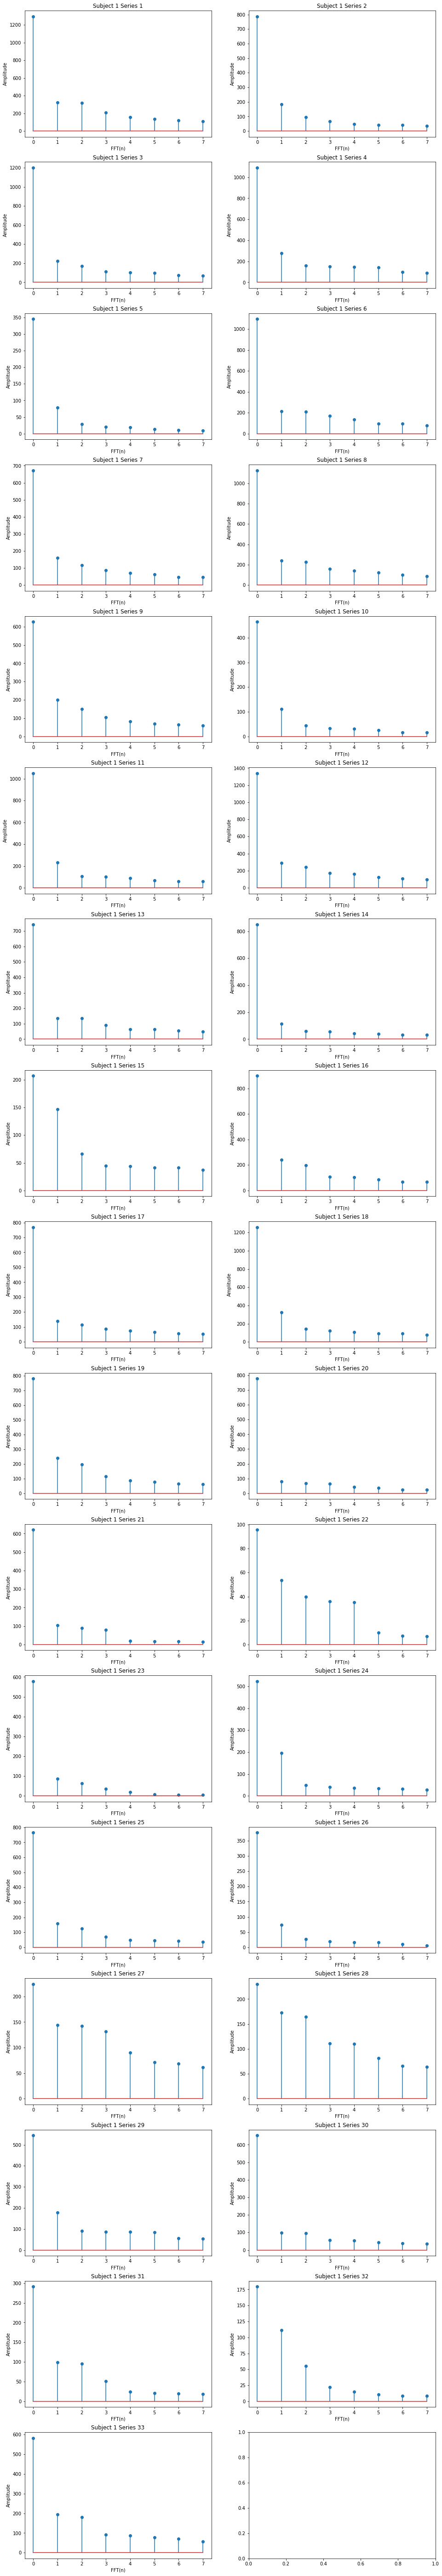

In [7]:
#Top 8 fft feature
def top_8_fft(cgm_series):
    y = np.fft.fft(cgm_series)
    y_abs = abs(y[1:len(y)//2 + 1])
    y_abs=y_abs[np.argsort(y_abs)]
    return y_abs[len(y_abs)-1:len(y_abs)-9:-1]


# print(top_8_fft(cgm_y_all_subjects[0][0]))

def plot_fft(subject_id = 1):
    fig_fft, ax_fft = get_fig_and_axes(subject_id)
    subject_id-=1
    cgm = cgm_y_all_subjects[subject_id]
    for i in range(0, len(cgm), 2):
        ax_fft[i//2][0].stem(top_8_fft(cgm[i]), use_line_collection=True)
        ax_fft[i//2][0].set_title("Subject "+ str(subject_id+1)+" Series " +str(i+1))
        ax_fft[i//2][0].set_xlabel("FFT(n)")
        ax_fft[i//2][0].set_ylabel("Amplitude")
        if (i+1) < len(cgm):
            ax_fft[i//2][1].stem(top_8_fft(cgm[i+1]), use_line_collection=True)
            ax_fft[i//2][1].set_title("Subject "+str(subject_id+1)+" Series " + str(i+2))
            ax_fft[i//2][1].set_xlabel("FFT(n)")
            ax_fft[i//2][1].set_ylabel("Amplitude")

plot_fft()

## Binned Entropy

In [8]:
#Binned Entropy
def binned_entropy(cgm_series, max_bins=5):
    hist, bin_edges = np.histogram(cgm_series, bins=max_bins)
    probs = hist / cgm_series.size
    probs[probs==0] = 1
    return   bin_edges, [-p * np.math.log(p) for p in probs if p != 0]

binned_entropy(cgm_y_all_subjects[0][6])

(array([ 98. , 115.8, 133.6, 151.4, 169.2, 187. ]),
 [0.36237414382026806,
  0.11337324605540518,
  -0.0,
  0.3218875824868201,
  0.3662040962227032])

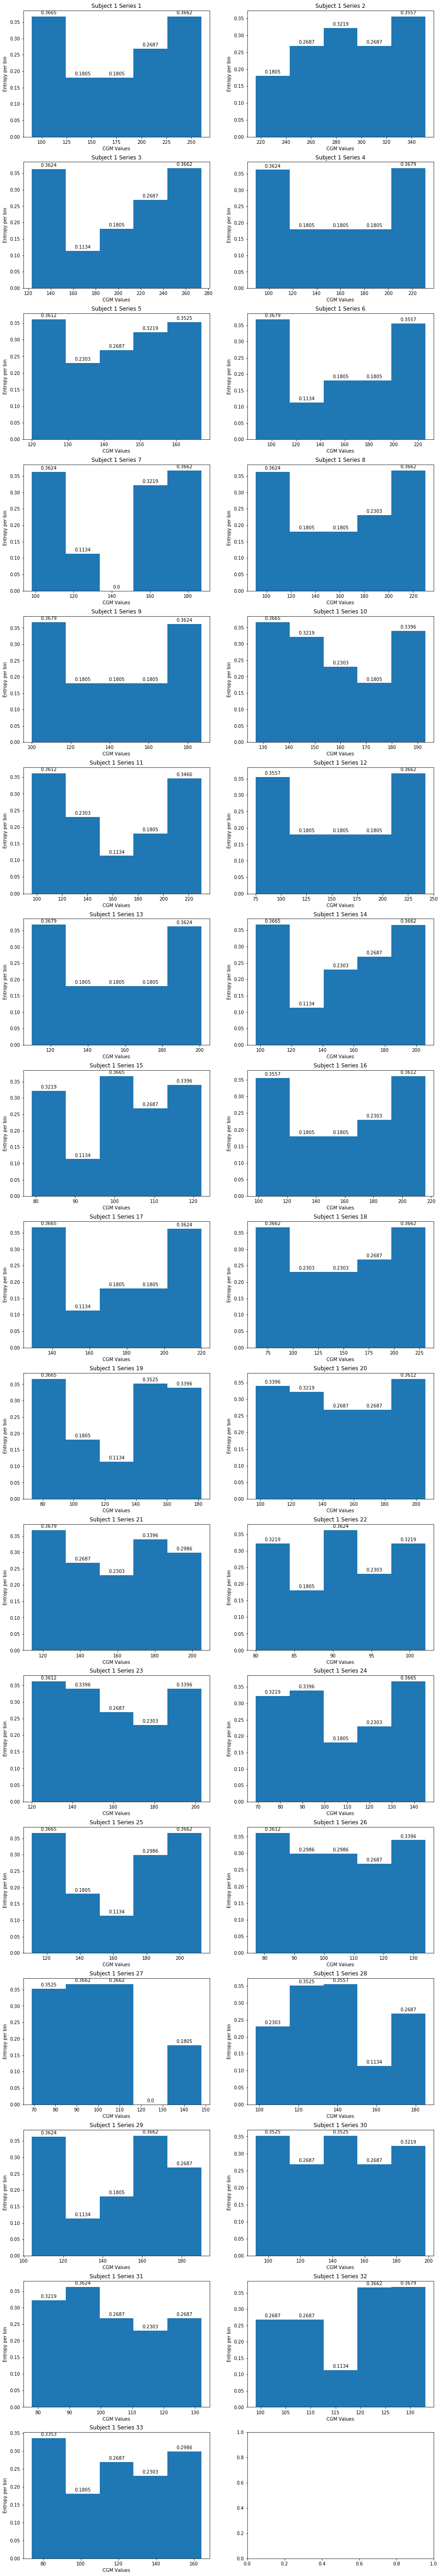

In [9]:
def plot_binned_entropy(subject_id=1):    
    fig, ax = get_fig_and_axes(subject_id)
    subject_id-=1
    cgm = cgm_y_all_subjects[subject_id]
    for i in range(0, len(cgm), 2):
            edges,bin_entr = binned_entropy(cgm[i])
            mids = [(edges[j]+edges[j+1])/2 for j in range(len(edges)-1)]
            diffs = [(edges[k+1] - edges[k]) for k in range(len(edges)-1)]
            rects = ax[i//2][0].bar(mids,bin_entr, width=diffs)
            ax[i//2][0].set_title("Subject "+ str(subject_id+1)+" Series " +str(i+1))
            ax[i//2][0].set_xlabel("CGM Values")
            ax[i//2][0].set_ylabel("Entropy per bin")
            for rect in rects:
                height = rect.get_height().round(4)
                ax[i//2][0].annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
            if (i+1) < len(cgm):
                edges,bin_entr = binned_entropy(cgm[i+1])
                mids = [(edges[j]+edges[j+1])/2 for j in range(len(edges)-1)]
                diffs = [(edges[k+1] - edges[k]) for k in range(len(edges)-1)]
                rects = ax[i//2][1].bar(mids,bin_entr, width=diffs)
                ax[i//2][1].set_title("Subject "+str(subject_id+1)+" Series " + str(i+2))
                ax[i//2][1].set_xlabel("CGM Values")
                ax[i//2][1].set_ylabel("Entropy per bin")
                for rect in rects:
                    height = rect.get_height().round(4)
                    ax[i//2][1].annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')
    
plot_binned_entropy()

## First location of maximum

In [10]:
#Location of maximum
def first_location_of_maximum(time_series, cgm_series):
    #return (float(np.argmax(cgm_series)) / len(cgm_series)) if len(cgm_series) > 0 else np.nan
    return np.argmax(cgm_series),(time_series[np.argmax(cgm_series)] - np.min(time_series))/np.ptp(time_series)

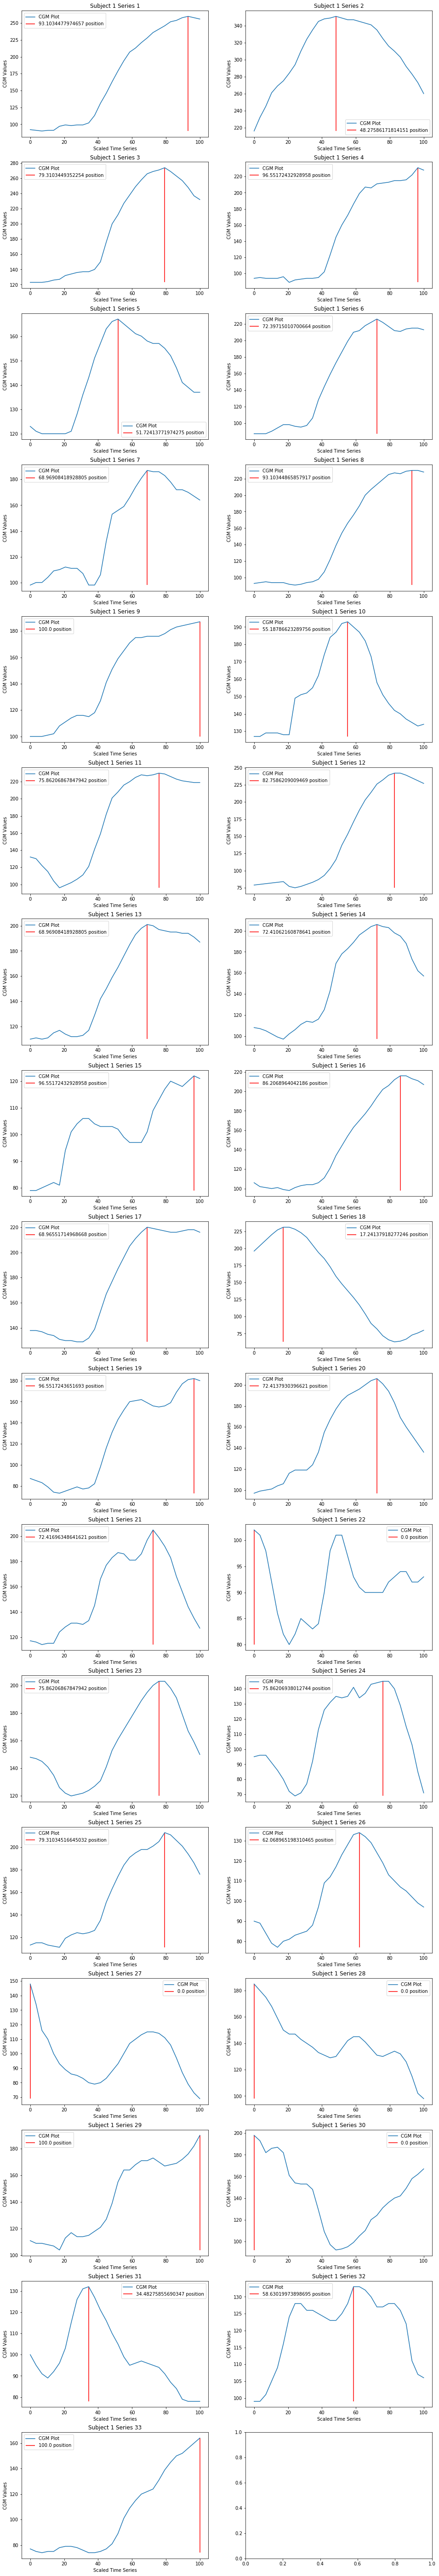

In [11]:
def plot_max_loc(subject_id=1):
    fig,ax = get_fig_and_axes(subject_id)
    subject_id-=1
    cgm = cgm_y_all_subjects[subject_id]
    dtm = dtm_x_all_subjects[subject_id]
    for i in range(0,len(cgm),2):
        index,position = first_location_of_maximum(dtm[i], cgm[i])
        ax[i//2][0].plot((dtm[i]-min(dtm[i]))/np.ptp(dtm[i])*100, cgm[i],label="CGM Plot")
        ax[i//2][0].vlines(x=position*100, ymin=min(cgm[i]),ymax=cgm[i][index],label=str(position*100) + " position", color="r")
        ax[i//2][0].set_title("Subject "+ str(subject_id+1)+" Series " +str(i+1))
        ax[i//2][0].set_xlabel("Scaled Time Series")
        ax[i//2][0].set_ylabel("CGM Values")
        ax[i//2][0].legend()
        if (i+1) < len(cgm):
            index,position = first_location_of_maximum(dtm[i+1], cgm[i+1])
            ax[i//2][1].plot((dtm[i+1]-min(dtm[i+1]))/np.ptp(dtm[i+1])*100, cgm[i+1], label="CGM Plot")
            ax[i//2][1].vlines(x=position*100, ymin=min(cgm[i+1]),ymax=cgm[i+1][index], label = str(position*100) + " position",color="r")
            ax[i//2][1].set_title("Subject "+ str(subject_id+1)+" Series " +str(i+2))
            ax[i//2][1].set_xlabel("Scaled Time Series")
            ax[i//2][1].set_ylabel("CGM Values")
            ax[i//2][1].legend()

plot_max_loc()

## Roundness ratio

In [12]:
# Roundness ratio feature
def roundness_ratio(cgm_series, time_series):
    time_series = shift_and_scale(time_series)
    cgm_series = pandas.Series(cgm_series)
    time_series = pandas.Series(time_series)
    area_under_curve = np.trapz(cgm_series,x = time_series)
    area_under_minline = np.trapz([min(cgm_series)]*len(cgm_series), x = time_series)
    act_area = area_under_curve - area_under_minline
    shr_cgm = cgm_series.shift()
    diff1_cgm = shr_cgm - cgm_series
    perimeter = abs(sum(diff1_cgm[1:]))
    return float(perimeter**2/act_area)

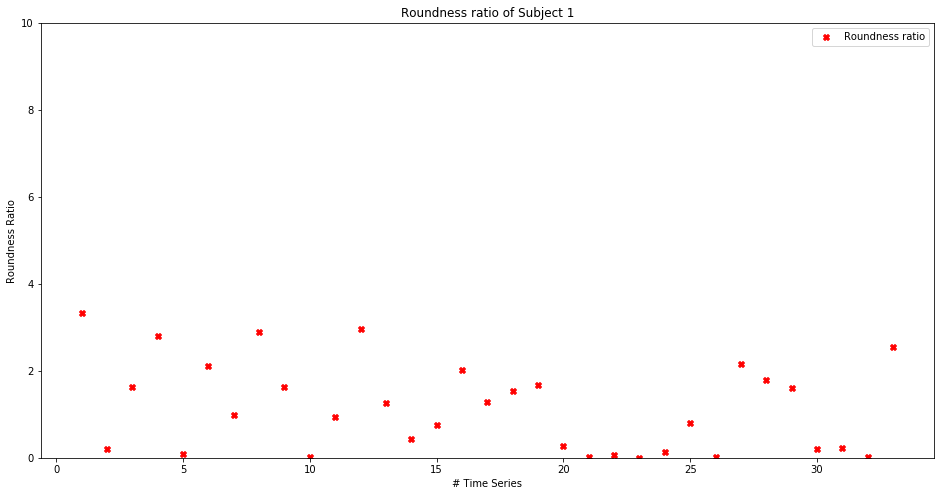

In [13]:
def plot_roundness_ratio(subject_id=1):
    r_ratio = []
    subject_id-=1
    cgm = cgm_y_all_subjects[subject_id]
    dtm = dtm_x_all_subjects[subject_id]
    for i in range(len(cgm)):
        r_ratio.append(roundness_ratio(cgm[i], dtm[i]))
    fig = plt.figure(figsize=(16,8))
    plt.scatter(list(range(1,len(cgm)+1)), r_ratio,marker="X", c="r", label="Roundness ratio")
    plt.title("Roundness ratio of Subject "+ str(subject_id+1))
    plt.xlabel("# Time Series")
    plt.ylabel("Roundness Ratio")
    plt.ylim(0,10)
    plt.legend()
    plt.show()
    
plot_roundness_ratio()

## Windowed Statistics (Mean, Std, Min, Max)

In [14]:
# Windowed Stat features
def windowed_stats(cgm_series, window_size=6):
    mean_windowed = []
    std_dev_windowed = []
    min_windowed = []
    max_windowed = []
    j = 0
    for i in range(window_size, len(cgm_series),window_size):
        mean_windowed.append(np.mean(cgm_series[j:i]))
        std_dev_windowed.append(np.std(cgm_series[j:i]))
        min_windowed.append(min(cgm_series[j:i]))
        max_windowed.append(max(cgm_series[j:i]))
        j = i
    mean_windowed.append(np.mean(cgm_series[j:]))
    std_dev_windowed.append(np.std(cgm_series[j:]))
    min_windowed.append(min(cgm_series[j:]))
    max_windowed.append(max(cgm_series[j:]))
    return mean_windowed, std_dev_windowed, min_windowed, max_windowed

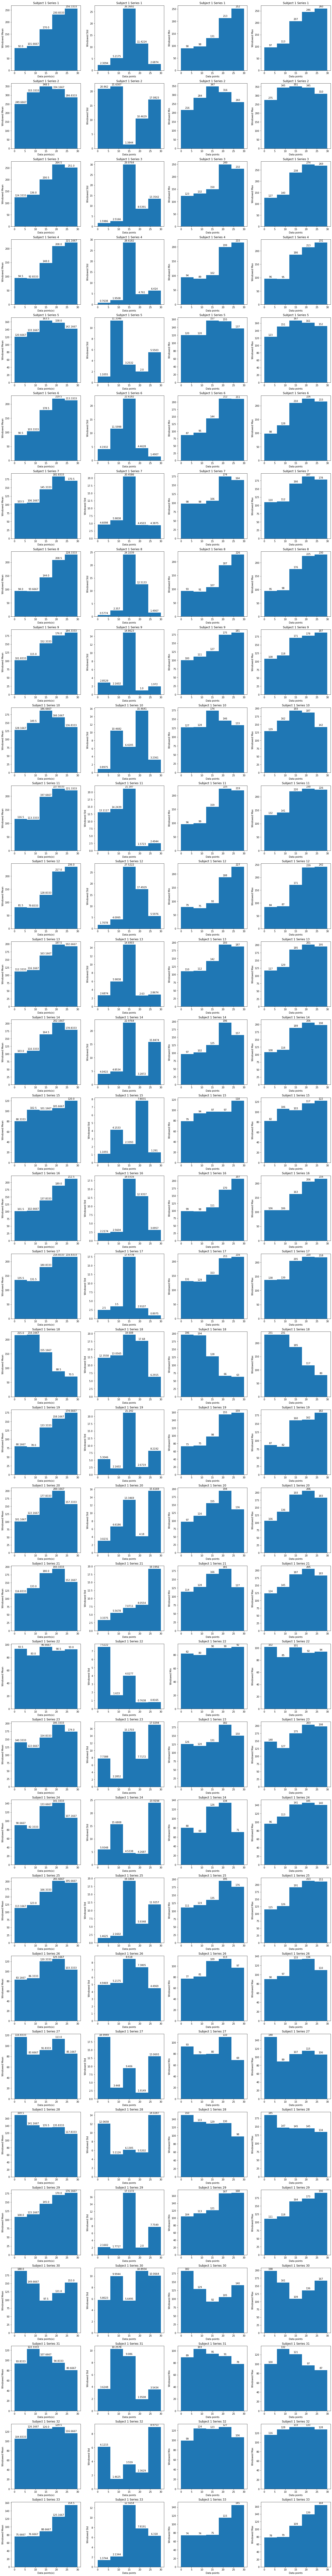

In [15]:
def plot_windowed_stats(subject_id=1):
    subject_id-=1
    cgm = cgm_y_all_subjects[subject_id]
    dtm = dtm_x_all_subjects[subject_id]
    fig, ax = plt.subplots(nrows = len(cgm), ncols = 4, figsize = (24,len(cgm)*6))
    for i in range(0,len(cgm)):
        dtm_i_scaled = shift_and_scale(dtm[i])
        #ax[i][0].plot(dtm_i_scaled, cgm[i],label="CGM Curve")
        ax[i][0].set_title("Subject " + str(subject_id+1)+" Series " +str(i+1))
        ax[i][0].set_xlabel("Data points(x)")
        ax[i][0].set_ylabel("Windowed Mean")
        w_stats = windowed_stats(cgm[i])
        edges = list(range(0, len(cgm[i])+1,6))
        mids = [(edges[j]+edges[j+1])/2 for j in range(len(edges)-1)]
        diffs = [(edges[k+1] - edges[k]) for k in range(len(edges)-1)]
        rects = ax[i][0].bar(mids,w_stats[0], width=diffs)
        for rect in rects:
                height = rect.get_height().round(4)
                ax[i][0].annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
        ax[i][1].set_title("Subject " + str(subject_id+1)+" Series " +str(i+1))
        ax[i][1].set_xlabel("Data points")
        ax[i][1].set_ylabel("Windowed Std")
        edges = list(range(0, len(cgm[i])+1,6))
        mids = [(edges[j]+edges[j+1])/2 for j in range(len(edges)-1)]
        diffs = [(edges[k+1] - edges[k]) for k in range(len(edges)-1)]
        rects = ax[i][1].bar(mids,w_stats[1], width=diffs)
        for rect in rects:
                height = rect.get_height().round(4)
                ax[i][1].annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
        
        ax[i][2].set_title("Subject " + str(subject_id+1)+" Series " +str(i+1))
        ax[i][2].set_xlabel("Data points")
        ax[i][2].set_ylabel("Wndowed Min")
        edges = list(range(0, len(cgm[i])+1,6))
        mids = [(edges[j]+edges[j+1])/2 for j in range(len(edges)-1)]
        diffs = [(edges[k+1] - edges[k]) for k in range(len(edges)-1)]
        rects = ax[i][2].bar(mids,w_stats[2], width=diffs)
        for rect in rects:
                height = rect.get_height().round(4)
                ax[i][2].annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
        ax[i][3].set_title("Subject " + str(subject_id+1)+" Series " +str(i+1))
        ax[i][3].set_xlabel("Data points")
        ax[i][3].set_ylabel("Windowed Max")
        edges = list(range(0, len(cgm[i])+1,6))
        mids = [(edges[j]+edges[j+1])/2 for j in range(len(edges)-1)]
        diffs = [(edges[k+1] - edges[k]) for k in range(len(edges)-1)]
        rects = ax[i][3].bar(mids,w_stats[3], width=diffs)
        for rect in rects:
                height = rect.get_height().round(4)
                ax[i][3].annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
plot_windowed_stats()

## Polynomial coefficients

In [16]:
#polynomial fit: return coeff
def poly_fit(cgm_series, time_series, degree=9):
    time_series = shift_and_scale(time_series, 1000)
    coeff = np.polyfit(time_series, cgm_series, degree)
    poly = np.poly1d(coeff)
    x = time_series
    y = poly(x)
    return coeff

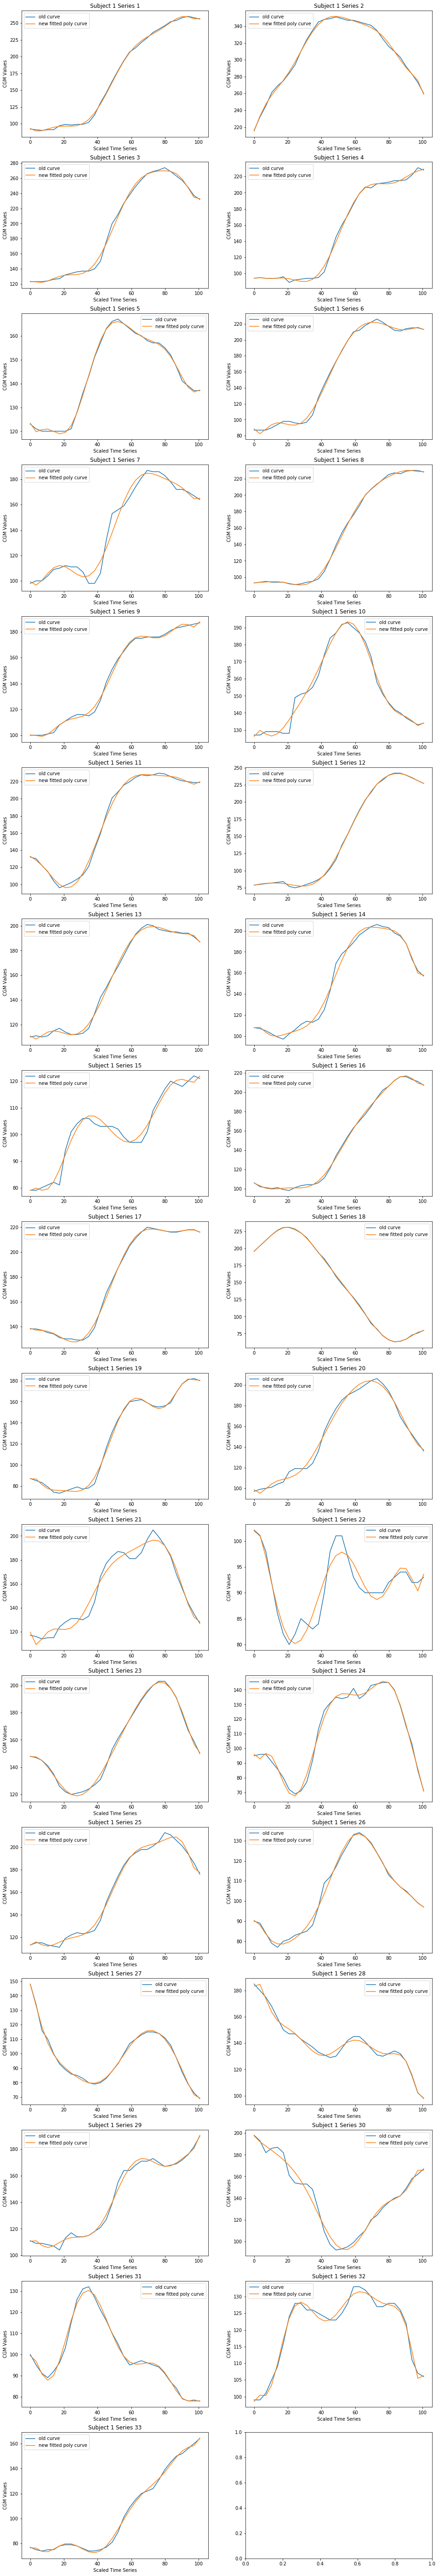

In [17]:
def plot_polyfit(subject_id=1):
    fig,ax = get_fig_and_axes(subject_id)
    subject_id-=1
    cgm = cgm_y_all_subjects[subject_id]
    dtm = dtm_x_all_subjects[subject_id]
    for i in range(0,len(cgm),2):
        dtm_i_scaled = shift_and_scale(dtm[i])
        coeffs = poly_fit(cgm[i],dtm[i])
        poly = np.poly1d(coeffs)
        y_new = poly(dtm_i_scaled)
        ax[i//2][0].plot(dtm_i_scaled, cgm[i],label="old curve")
        ax[i//2][0].plot(dtm_i_scaled, y_new, label="new fitted poly curve")
        ax[i//2][0].set_title("Subject "+ str(subject_id+1)+" Series " +str(i+1))
        ax[i//2][0].set_xlabel("Scaled Time Series")
        ax[i//2][0].set_ylabel("CGM Values")
        ax[i//2][0].legend()
        if (i+1) < len(cgm):
            dtm_i_scaled = shift_and_scale(dtm[i+1])
            coeffs = poly_fit(cgm[i+1],dtm[i+1])
            poly = np.poly1d(coeffs)
            y_new = poly(dtm_i_scaled)
            ax[i//2][1].plot(dtm_i_scaled, cgm[i+1],label="old curve")
            ax[i//2][1].plot(dtm_i_scaled, y_new, label="new fitted poly curve")
            ax[i//2][1].set_title("Subject "+ str(subject_id+1)+" Series " +str(i+2))
            ax[i//2][1].set_xlabel("Scaled Time Series")
            ax[i//2][1].set_ylabel("CGM Values")
            ax[i//2][1].legend()
plot_polyfit()

## Feature calculation

In [18]:
# Feature matrix column headings

first_max_loc = ["first_max_loc"]

roundness_ratio_label = ["roundness_ratio"]

binned_entropy_labels = ["bin_entropy_1",
                  "bin_entropy_2",
                  "bin_entropy_3",
                  "bin_entropy_4",
                  "bin_entropy_5"]

fft = ["fft_1",
       "fft_2",
       "fft_3",
       "fft_4",
       "fft_5",
       "fft_6",
       "fft_7",
       "fft_8"]

poly_coeff = ["polyfit_coeff_1",
              "polyfit_coeff_2",
              "polyfit_coeff_3",
              "polyfit_coeff_4",
              "polyfit_coeff_5",
              "polyfit_coeff_6",
              "polyfit_coeff_7",
              "polyfit_coeff_8",
              "polyfit_coeff_9",
              "polyfit_coeff_10"]

mean_windowed = ["mean_window_1",
                 "mean_window_2",
                 "mean_window_3",
                 "mean_window_4",
                 "mean_window_5"]

std_windowed = ["std_window_1",
                "std_window_2",
                "std_window_3",
                "std_window_4",
                "std_window_5"]

min_windowed = ["min_window_1",
                "min_window_2",
                "min_window_3",
                "min_window_4",
                "min_window_5"]

max_windowed = ["max_window_1",
                "max_window_2",
                "max_window_3",
                "max_window_4",
                "max_window_5"]
columns = first_max_loc + roundness_ratio_label + binned_entropy_labels + fft + poly_coeff +\
          mean_windowed + std_windowed + min_windowed + max_windowed

In [19]:
def create_feature_row(cgm_series, dtm_series):
    maxloc = first_location_of_maximum(dtm_series, cgm_series)[1]
    roundnessratio = roundness_ratio(cgm_series, dtm_series)
    binnedentropy = binned_entropy(cgm_series)[1]
    top8fft = top_8_fft(cgm_series)
    polyfit = poly_fit(cgm_series,dtm_series)
    windowedstats = windowed_stats(cgm_series)
    feature_vector = np.concatenate(([maxloc], [roundnessratio], binnedentropy, top8fft, polyfit, windowedstats[0], windowedstats[1], windowedstats[2], windowedstats[3],), axis = None)
    return feature_vector

In [20]:
def calculate_features_from_data(subject_zero_based_index=0):
    df = pandas.DataFrame(columns = columns)
    subject_frame = cgm_y_all_subjects[subject_zero_based_index]
    for row_index in range(len(subject_frame)):
        row = subject_frame[row_index]
        feature_row = create_feature_row(row, dtm_x_all_subjects[subject_zero_based_index][row_index])
        feature_df = pandas.DataFrame([feature_row],columns=columns)
        df = df.append(feature_df, ignore_index=True)
    return df

## Dimensionality Reduction using PCA

In [21]:
# Scaling and normalizing the data
feature_matrix = calculate_features_from_data(0)
df_standardized = pandas.DataFrame(StandardScaler().fit_transform(feature_matrix), columns=columns)
df_minmax = pandas.DataFrame(MinMaxScaler().fit_transform(feature_matrix), columns=columns)

In [22]:
# New feaute matrix with principal components
pca = PCA(n_components=5)
pca_df = pandas.DataFrame(pca.fit_transform(df_standardized), columns=["PCA_1", "PCA_2", "PCA_3", "PCA_4", "PCA_5"])
#pca_df = pandas.DataFrame(pca.fit_transform(df_minmax), columns=["PCA_1", "PCA_2", "PCA_3", "PCA_4", "PCA_5"])
pca_df

,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5
0,7.179739,2.476204,-1.471070,1.564554,0.092739
1,-4.908914,14.057384,5.186482,-1.123866,-1.517641
2,4.620775,2.943663,1.433989,-1.891861,-0.216342
3,5.802188,0.193621,-0.376362,0.522165,-0.484469
4,-4.963431,0.397052,-2.342743,-1.308412,0.801529
5,2.474465,3.187128,-4.955712,1.788595,-0.488924
6,1.112657,-0.493336,-1.444129,-1.473215,1.104012
7,5.339596,0.803692,-1.413784,1.012170,0.457544
8,2.512633,-1.142588,0.720433,-0.950164,-0.390064
9,-2.116992,-0.635473,2.961663,-1.607062,1.033079


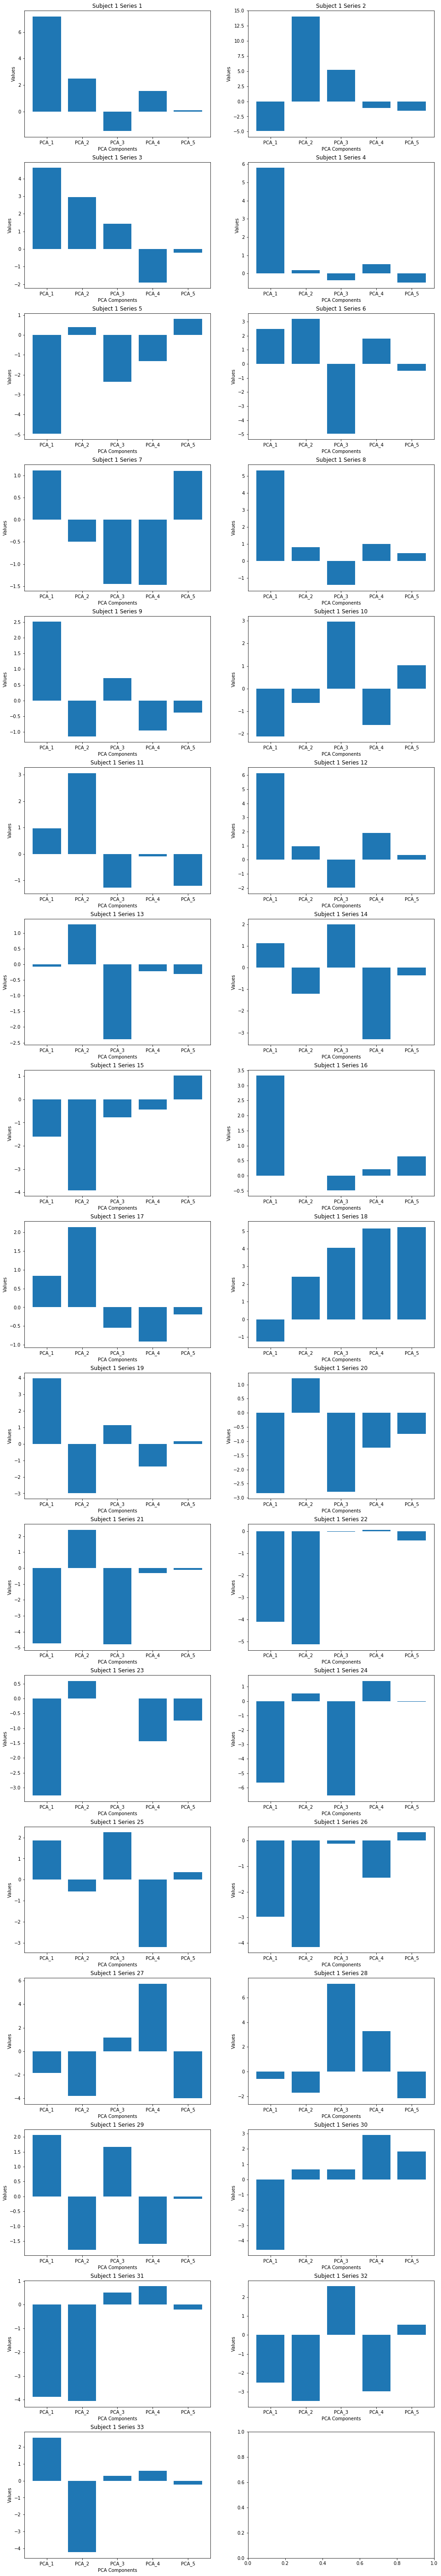

In [23]:
#plotting new features for all the time series
def plot_pca_components(subject_id=1):
    fig,ax = get_fig_and_axes(subject_id)
    subject_id-=1
    cgm = cgm_y_all_subjects[subject_id]
    dtm = dtm_x_all_subjects[subject_id]
    pca_columns = ["PCA_1", "PCA_2", "PCA_3", "PCA_4", "PCA_5"]
    for i in range(0,len(cgm),2):
        ax[i//2][0].bar(pca_columns, pca_df.values[i])
        ax[i//2][0].set_title("Subject "+ str(subject_id+1)+" Series " +str(i+1))
        ax[i//2][0].set_xlabel("PCA Components")
        ax[i//2][0].set_ylabel("Values")
        if (i+1) < len(cgm):
            ax[i//2][1].bar(pca_columns, pca_df.values[i+1])
            ax[i//2][1].set_title("Subject "+ str(subject_id+1)+" Series " +str(i+2))
            ax[i//2][1].set_xlabel("PCA Components")
            ax[i//2][1].set_ylabel("Values")
plot_pca_components()

In [24]:
variance = pca.explained_variance_
variance_ratio = pca.explained_variance_ratio_
explanation_percentage = np.sum(pca.explained_variance_ratio_)*100
print("variance: ", variance)
print("variance ratio: ",variance_ratio)
print("explanation %:", explanation_percentage)

variance:  [13.51308763 12.265551    7.81109435  4.54624686  1.96152613]
variance ratio:  [0.29119111 0.26430817 0.16831988 0.09796626 0.04226858]
explanation %: 86.40540006164575


In [ ]:
plt.figure(figsize=(16,8))
plt.xlabel("PCA Components")
plt.ylabel("Variance %")
plt.title("Variance percentage of PCA Componenets")
rects = plt.bar( x=["PCA_1", "PCA_2", "PCA_3", "PCA_4", "PCA_5"],height=variance_ratio*100)
for rect in rects:
    height = rect.get_height().round(4)
    plt.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

In [ ]:
plt.figure(figsize=(16,8))
plt.xlabel("PCA Components")
plt.ylabel("Variance")
plt.title("Variance of PCA Componenets")
rects = plt.bar( x=["PCA_1", "PCA_2", "PCA_3", "PCA_4", "PCA_5"],height=variance)
for rect in rects:
    height = rect.get_height().round(4)
    plt.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

In [ ]:
# print(abs(pca.components_))
x = pandas.DataFrame(pca.components_, columns=columns)
print(x.max(axis=1))
x

In [ ]:
#get important features
comps = pca.components_
comp_length = comps.shape[0]
imp = [np.abs(comps[i]).argmax() for i in range(comp_length)]
print([columns[i] for i in imp])

In [ ]:
x_1 = x.loc[4]
x_1_values = x_1.values
x_1_values_sorted = np.sort(x_1_values)
x_1_col = np.argsort(x_1_values)
cols = np.array(columns)
pc_i = pandas.DataFrame([np.flip(x_1_values_sorted)], columns=np.flip(cols[x_1_col]))

In [ ]:
pc_i